# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Trayectorias 200 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')
varftrain = np.transpose(varftrain, (0,3,1,2))

In [6]:
np.shape(varftrain)

(7000, 200, 10, 2)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')
varftest = np.transpose(varftest, (0,3,1,2))

In [10]:
np.shape(varftest)

(2000, 200, 10, 2)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')
varfval = np.transpose(varfval, (0,3,1,2))

In [14]:
np.shape(varfval)

(1000, 200, 10, 2)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(200, 10, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(200, 10, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa convolucional
#model.add(Conv2D(64, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))

model.add(Flatten())
model.add(Dense(128, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))



In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 8, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 4, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 2, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 1, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               3

In [23]:
keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Entrenamos el modelo

In [24]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=10.0)

In [25]:
model.compile(optimizer= optimizer,
              loss= 'mse',
              metrics=['accuracy'])


In [27]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [28]:
val_epochs = 1000
tf.compat.v1.global_variables_initializer()

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 5s 7ms/step - loss: 13.5473 - accuracy: 0.2983 - val_loss: 10.5292 - val_accuracy: 0.3580 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 5s 7ms/step - loss: 9.8011 - accuracy: 0.3454 - val_loss: 8.5161 - val_accuracy: 0.3690 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 5s 7ms/step - loss: 8.5860 - accuracy: 0.3674 - val_loss: 7.8821 - val_accuracy: 0.3890 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 5s 7ms/step - loss: 7.8390 - accuracy: 0.3804 - val_loss: 7.2323 - val_accuracy: 0.3550 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 5s 7ms/step - loss: 7.2284 - accuracy: 0.3951 - val_loss: 6.5935 - val_accuracy: 0.3860 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 5s 7ms/step - loss: 6.8838 - accuracy: 0.4006 - val_loss: 6.7019 - val_accuracy: 0.4150 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 

Epoch 53/1000
700/700 [==============================] - 5s 7ms/step - loss: 5.0537 - accuracy: 0.4706 - val_loss: 5.0082 - val_accuracy: 0.4630 - lr: 0.0010
Epoch 54/1000
700/700 [==============================] - 5s 6ms/step - loss: 5.0389 - accuracy: 0.4689 - val_loss: 5.0509 - val_accuracy: 0.4630 - lr: 0.0010
Epoch 55/1000
700/700 [==============================] - 5s 6ms/step - loss: 5.3964 - accuracy: 0.4674 - val_loss: 4.7924 - val_accuracy: 0.4770 - lr: 0.0010
Epoch 56/1000
700/700 [==============================] - 5s 7ms/step - loss: 5.0759 - accuracy: 0.4729 - val_loss: 4.8560 - val_accuracy: 0.4610 - lr: 0.0010
Epoch 57/1000
700/700 [==============================] - 5s 6ms/step - loss: 4.9761 - accuracy: 0.4701 - val_loss: 4.9954 - val_accuracy: 0.4720 - lr: 0.0010
Epoch 58/1000
700/700 [==============================] - 5s 6ms/step - loss: 4.9981 - accuracy: 0.4757 - val_loss: 5.1349 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 59/1000
700/700 [=============================

Epoch 105/1000
700/700 [==============================] - 5s 6ms/step - loss: 4.9837 - accuracy: 0.4731 - val_loss: 4.9430 - val_accuracy: 0.4580 - lr: 0.0010
Epoch 106/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.9616 - accuracy: 0.4733 - val_loss: 5.0785 - val_accuracy: 0.4530 - lr: 0.0010
Epoch 107/1000
700/700 [==============================] - 5s 6ms/step - loss: 5.0904 - accuracy: 0.4794 - val_loss: 4.6795 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 108/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.9364 - accuracy: 0.4777 - val_loss: 4.8721 - val_accuracy: 0.4640 - lr: 0.0010
Epoch 109/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.8797 - accuracy: 0.4786 - val_loss: 4.7104 - val_accuracy: 0.4720 - lr: 0.0010
Epoch 110/1000
700/700 [==============================] - 5s 7ms/step - loss: 5.0612 - accuracy: 0.4799 - val_loss: 4.9772 - val_accuracy: 0.4610 - lr: 0.0010
Epoch 111/1000
700/700 [======================

700/700 [==============================] - 5s 7ms/step - loss: 4.8347 - accuracy: 0.4851 - val_loss: 4.8089 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 208/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.7765 - accuracy: 0.4877 - val_loss: 4.6904 - val_accuracy: 0.4890 - lr: 0.0010
Epoch 209/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.7674 - accuracy: 0.4844 - val_loss: 4.8690 - val_accuracy: 0.4980 - lr: 0.0010
Epoch 210/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.9165 - accuracy: 0.4864 - val_loss: 4.8513 - val_accuracy: 0.4880 - lr: 0.0010
Epoch 211/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.7941 - accuracy: 0.4866 - val_loss: 4.7623 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 212/1000
700/700 [==============================] - 5s 6ms/step - loss: 4.8055 - accuracy: 0.4896 - val_loss: 4.7496 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 213/1000
700/700 [==============================] - 5s 

700/700 [==============================] - 5s 7ms/step - loss: 4.7187 - accuracy: 0.4877 - val_loss: 4.9422 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 310/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.7659 - accuracy: 0.4847 - val_loss: 4.6607 - val_accuracy: 0.4780 - lr: 0.0010
Epoch 311/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.7345 - accuracy: 0.4857 - val_loss: 4.6677 - val_accuracy: 0.4920 - lr: 0.0010
Epoch 312/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.9883 - accuracy: 0.4844 - val_loss: 4.7121 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 313/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.8172 - accuracy: 0.4903 - val_loss: 4.5683 - val_accuracy: 0.4920 - lr: 0.0010
Epoch 314/1000
700/700 [==============================] - 4s 6ms/step - loss: 4.7459 - accuracy: 0.4854 - val_loss: 5.0156 - val_accuracy: 0.4880 - lr: 0.0010
Epoch 315/1000
700/700 [==============================] - 5s 

700/700 [==============================] - 5s 7ms/step - loss: 4.7449 - accuracy: 0.4913 - val_loss: 5.1186 - val_accuracy: 0.4890 - lr: 9.8350e-04
Epoch 412/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.7908 - accuracy: 0.4870 - val_loss: 4.6976 - val_accuracy: 0.5100 - lr: 9.8185e-04
Epoch 413/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.8063 - accuracy: 0.4869 - val_loss: 5.0353 - val_accuracy: 0.4740 - lr: 9.8020e-04
Epoch 414/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.7331 - accuracy: 0.4929 - val_loss: 4.7027 - val_accuracy: 0.5060 - lr: 9.7855e-04
Epoch 415/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.6658 - accuracy: 0.4906 - val_loss: 4.8671 - val_accuracy: 0.4930 - lr: 9.7690e-04
Epoch 416/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.7133 - accuracy: 0.4837 - val_loss: 4.8010 - val_accuracy: 0.4860 - lr: 9.7525e-04
Epoch 417/1000
700/700 [=============

700/700 [==============================] - 5s 7ms/step - loss: 4.6109 - accuracy: 0.4977 - val_loss: 4.5678 - val_accuracy: 0.5230 - lr: 8.1850e-04
Epoch 512/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.8025 - accuracy: 0.4914 - val_loss: 4.4259 - val_accuracy: 0.5120 - lr: 8.1685e-04
Epoch 513/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.5178 - accuracy: 0.5027 - val_loss: 4.4272 - val_accuracy: 0.5260 - lr: 8.1520e-04
Epoch 514/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.5076 - accuracy: 0.5060 - val_loss: 4.6305 - val_accuracy: 0.4980 - lr: 8.1355e-04
Epoch 515/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.5032 - accuracy: 0.5004 - val_loss: 4.5569 - val_accuracy: 0.5190 - lr: 8.1190e-04
Epoch 516/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.5499 - accuracy: 0.5069 - val_loss: 4.5159 - val_accuracy: 0.5280 - lr: 8.1025e-04
Epoch 517/1000
700/700 [=============

700/700 [==============================] - 5s 7ms/step - loss: 4.4356 - accuracy: 0.5119 - val_loss: 4.4875 - val_accuracy: 0.5120 - lr: 6.5350e-04
Epoch 612/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.4445 - accuracy: 0.5051 - val_loss: 4.4905 - val_accuracy: 0.5120 - lr: 6.5185e-04
Epoch 613/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.4349 - accuracy: 0.5079 - val_loss: 4.4065 - val_accuracy: 0.5240 - lr: 6.5020e-04
Epoch 614/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.4003 - accuracy: 0.5101 - val_loss: 4.3599 - val_accuracy: 0.5290 - lr: 6.4855e-04
Epoch 615/1000
700/700 [==============================] - 5s 8ms/step - loss: 4.3680 - accuracy: 0.5106 - val_loss: 4.3655 - val_accuracy: 0.5330 - lr: 6.4690e-04
Epoch 616/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.4504 - accuracy: 0.5069 - val_loss: 4.3403 - val_accuracy: 0.5260 - lr: 6.4525e-04
Epoch 617/1000
700/700 [=============

700/700 [==============================] - 5s 7ms/step - loss: 4.2362 - accuracy: 0.5141 - val_loss: 4.2386 - val_accuracy: 0.5370 - lr: 4.8850e-04
Epoch 712/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.2453 - accuracy: 0.5181 - val_loss: 4.2861 - val_accuracy: 0.5330 - lr: 4.8685e-04
Epoch 713/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.2180 - accuracy: 0.5161 - val_loss: 4.2796 - val_accuracy: 0.5360 - lr: 4.8520e-04
Epoch 714/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.2441 - accuracy: 0.5191 - val_loss: 4.2838 - val_accuracy: 0.5310 - lr: 4.8355e-04
Epoch 715/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.2915 - accuracy: 0.5171 - val_loss: 4.2705 - val_accuracy: 0.5330 - lr: 4.8190e-04
Epoch 716/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.2506 - accuracy: 0.5157 - val_loss: 4.3466 - val_accuracy: 0.5280 - lr: 4.8025e-04
Epoch 717/1000
700/700 [=============

700/700 [==============================] - 5s 7ms/step - loss: 4.1020 - accuracy: 0.5317 - val_loss: 4.1832 - val_accuracy: 0.5340 - lr: 3.2350e-04
Epoch 812/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.1137 - accuracy: 0.5233 - val_loss: 4.1761 - val_accuracy: 0.5300 - lr: 3.2185e-04
Epoch 813/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.0977 - accuracy: 0.5267 - val_loss: 4.2300 - val_accuracy: 0.5330 - lr: 3.2020e-04
Epoch 814/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.1217 - accuracy: 0.5251 - val_loss: 4.2085 - val_accuracy: 0.5250 - lr: 3.1855e-04
Epoch 815/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.0925 - accuracy: 0.5239 - val_loss: 4.1970 - val_accuracy: 0.5310 - lr: 3.1690e-04
Epoch 816/1000
700/700 [==============================] - 5s 7ms/step - loss: 4.1053 - accuracy: 0.5266 - val_loss: 4.1820 - val_accuracy: 0.5290 - lr: 3.1525e-04
Epoch 817/1000
700/700 [=============

700/700 [==============================] - 5s 7ms/step - loss: 3.9405 - accuracy: 0.5376 - val_loss: 4.0974 - val_accuracy: 0.5310 - lr: 1.5850e-04
Epoch 912/1000
700/700 [==============================] - 5s 7ms/step - loss: 3.9467 - accuracy: 0.5311 - val_loss: 4.1630 - val_accuracy: 0.5170 - lr: 1.5685e-04
Epoch 913/1000
700/700 [==============================] - 5s 7ms/step - loss: 3.9445 - accuracy: 0.5367 - val_loss: 4.1255 - val_accuracy: 0.5310 - lr: 1.5520e-04
Epoch 914/1000
700/700 [==============================] - 5s 7ms/step - loss: 3.9594 - accuracy: 0.5283 - val_loss: 4.1198 - val_accuracy: 0.5170 - lr: 1.5355e-04
Epoch 915/1000
700/700 [==============================] - 5s 7ms/step - loss: 3.9447 - accuracy: 0.5350 - val_loss: 4.1096 - val_accuracy: 0.5300 - lr: 1.5190e-04
Epoch 916/1000
700/700 [==============================] - 5s 7ms/step - loss: 3.9452 - accuracy: 0.5324 - val_loss: 4.0953 - val_accuracy: 0.5260 - lr: 1.5025e-04
Epoch 917/1000
700/700 [=============

# Analizamos accuracy y loss

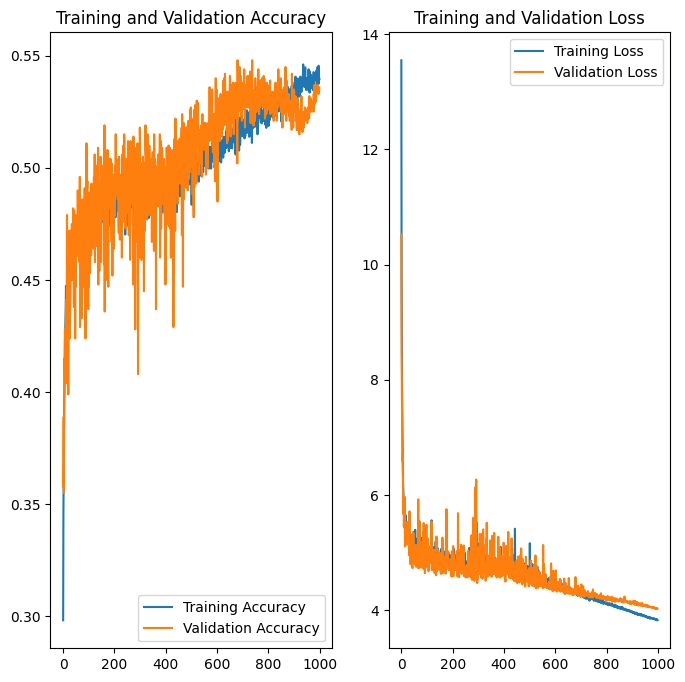

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Guardamos los datos de Accuracy y Loss

In [30]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 100,200/historyconvtrayec200.csv', index=False)

# Guardamos el modelo

In [31]:
path_to_save = '../../../Modelos/Modelos 100,200/'

In [32]:
model.save(path_to_save + '/convolucionaltr200.h5')

# Importamos el modelo

In [2]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [3]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/convolucionaltr200.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [4]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 200)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[5, 2, 7, 9, 10, 4, 0]
(10, 2, 200)


In [5]:
varfnone = varf[None, :]
varfnone = np.transpose(varfnone, (0,3,1,2))

## Predecimos con los datos nuevos

In [6]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 87ms/step
[[6. 2. 7. 5. 9. 4. 2.]]


## Graficamos con los coeficientes reales

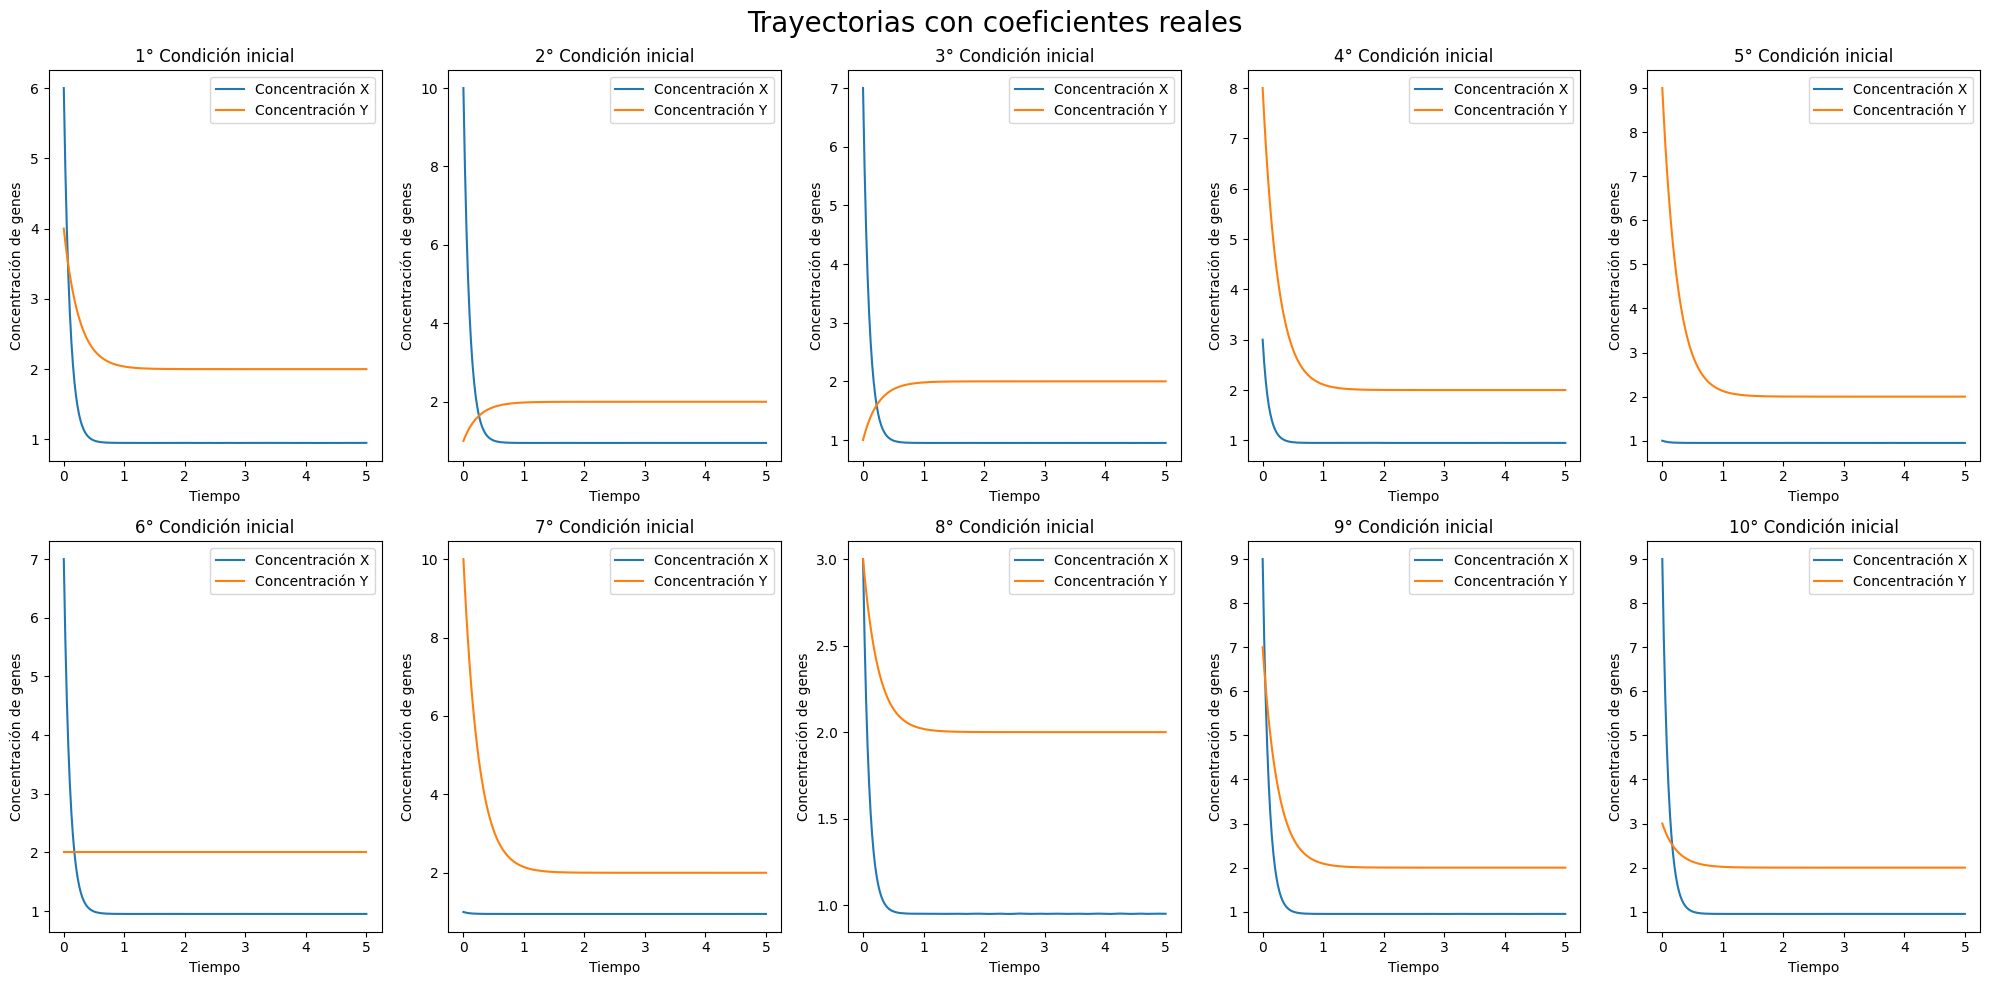

In [8]:
import matplotlib.pyplot as plt

t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos con los coeficientes predecidos

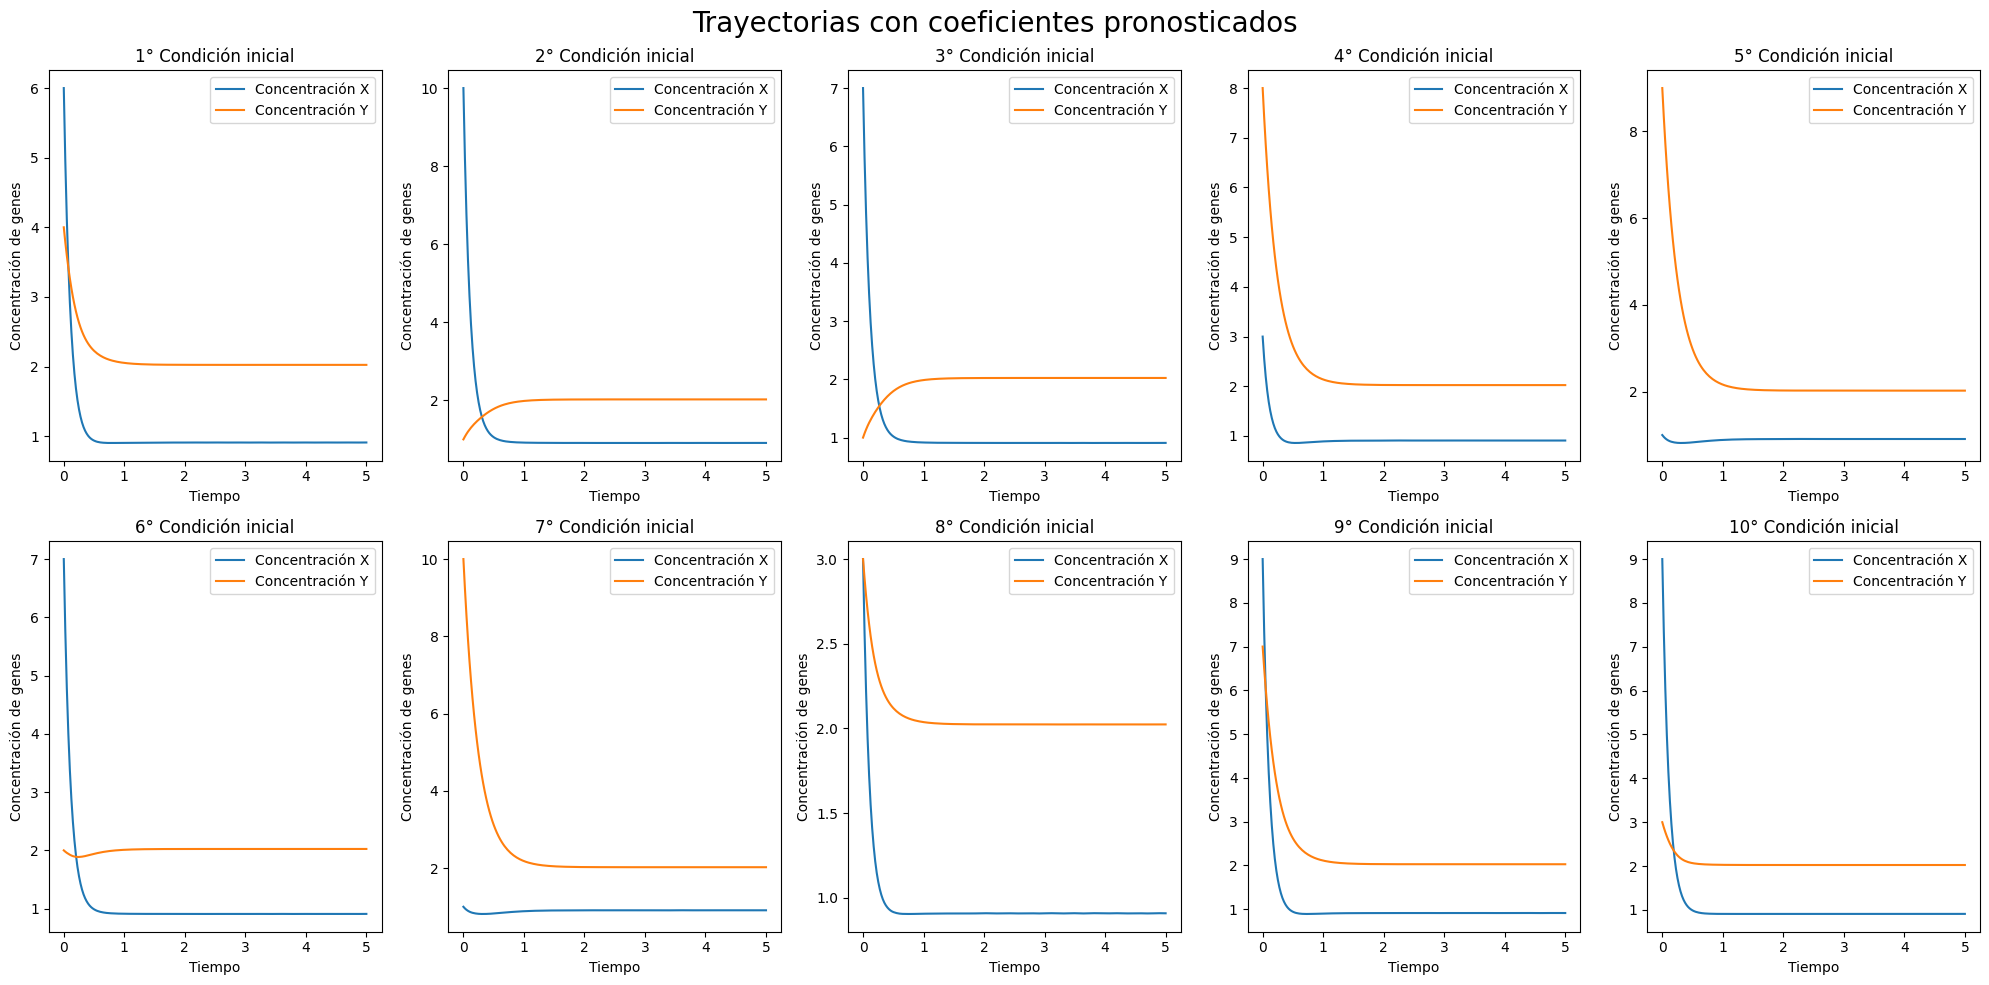

In [10]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

# Graficamos ambos

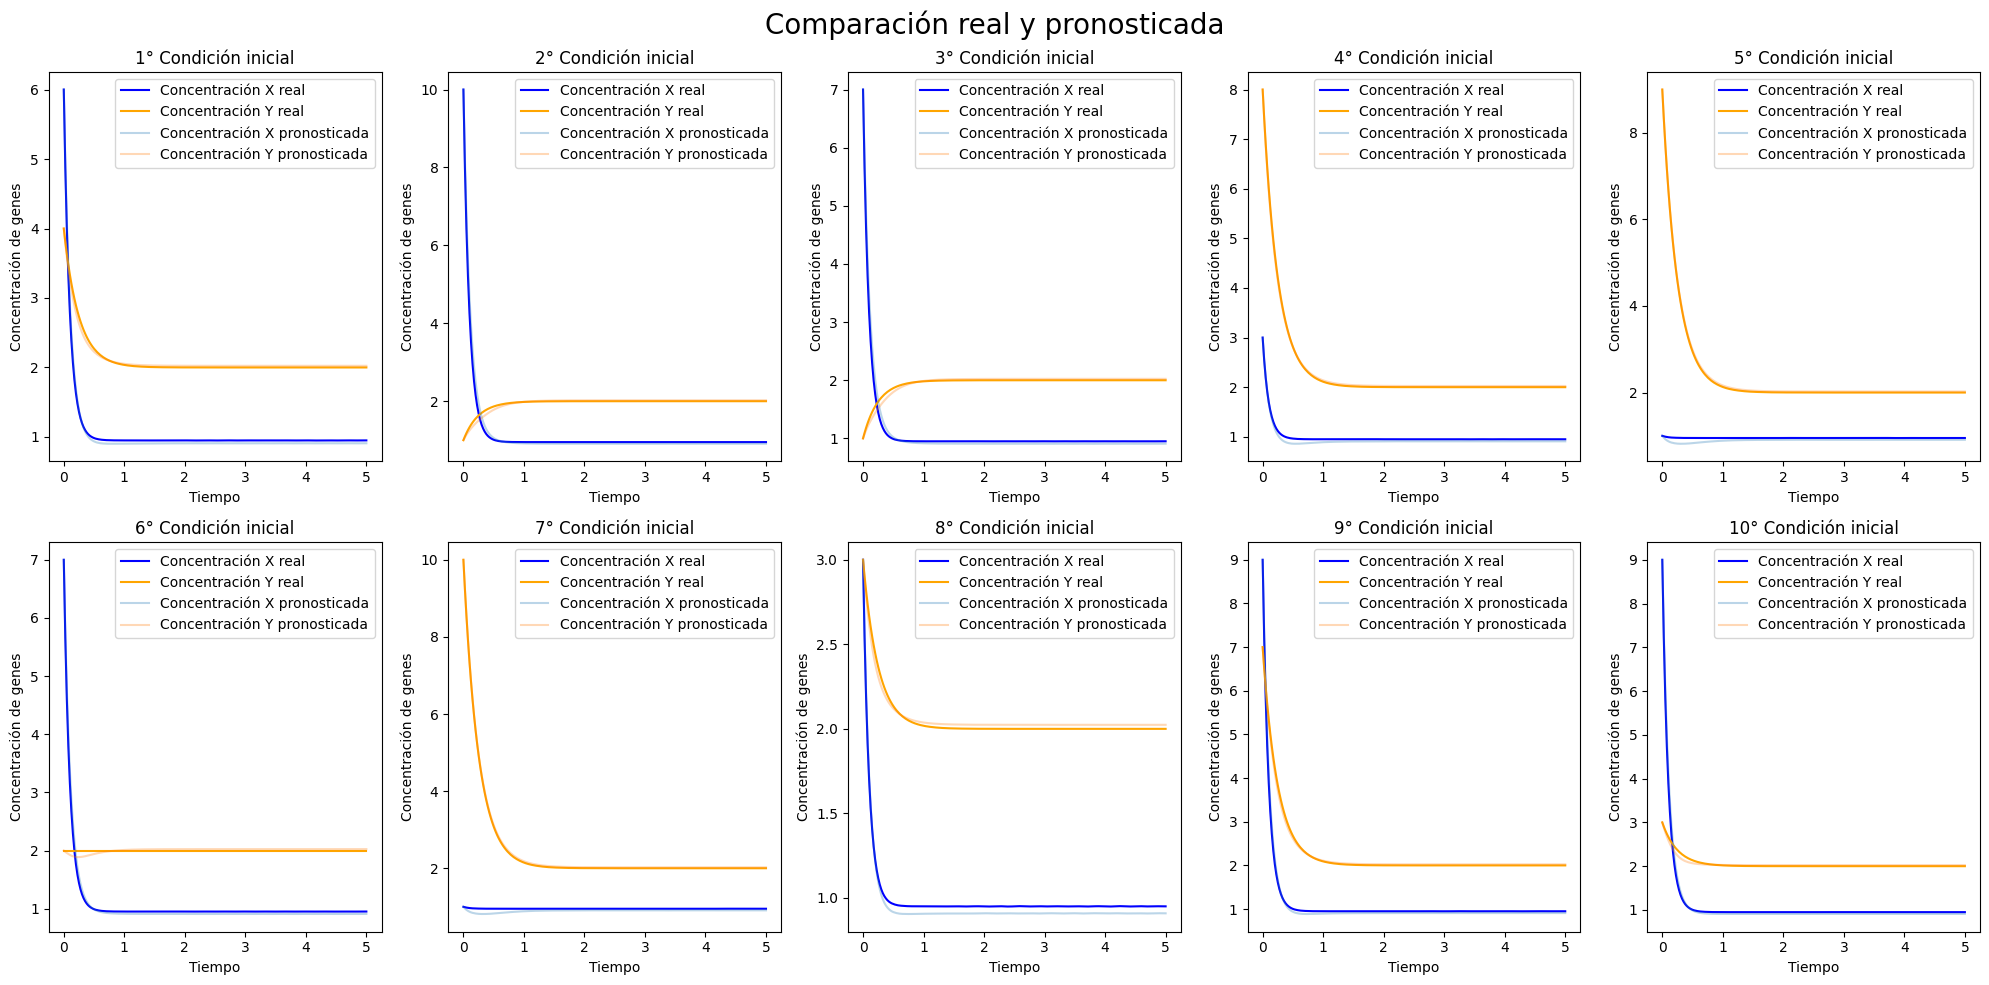

In [11]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

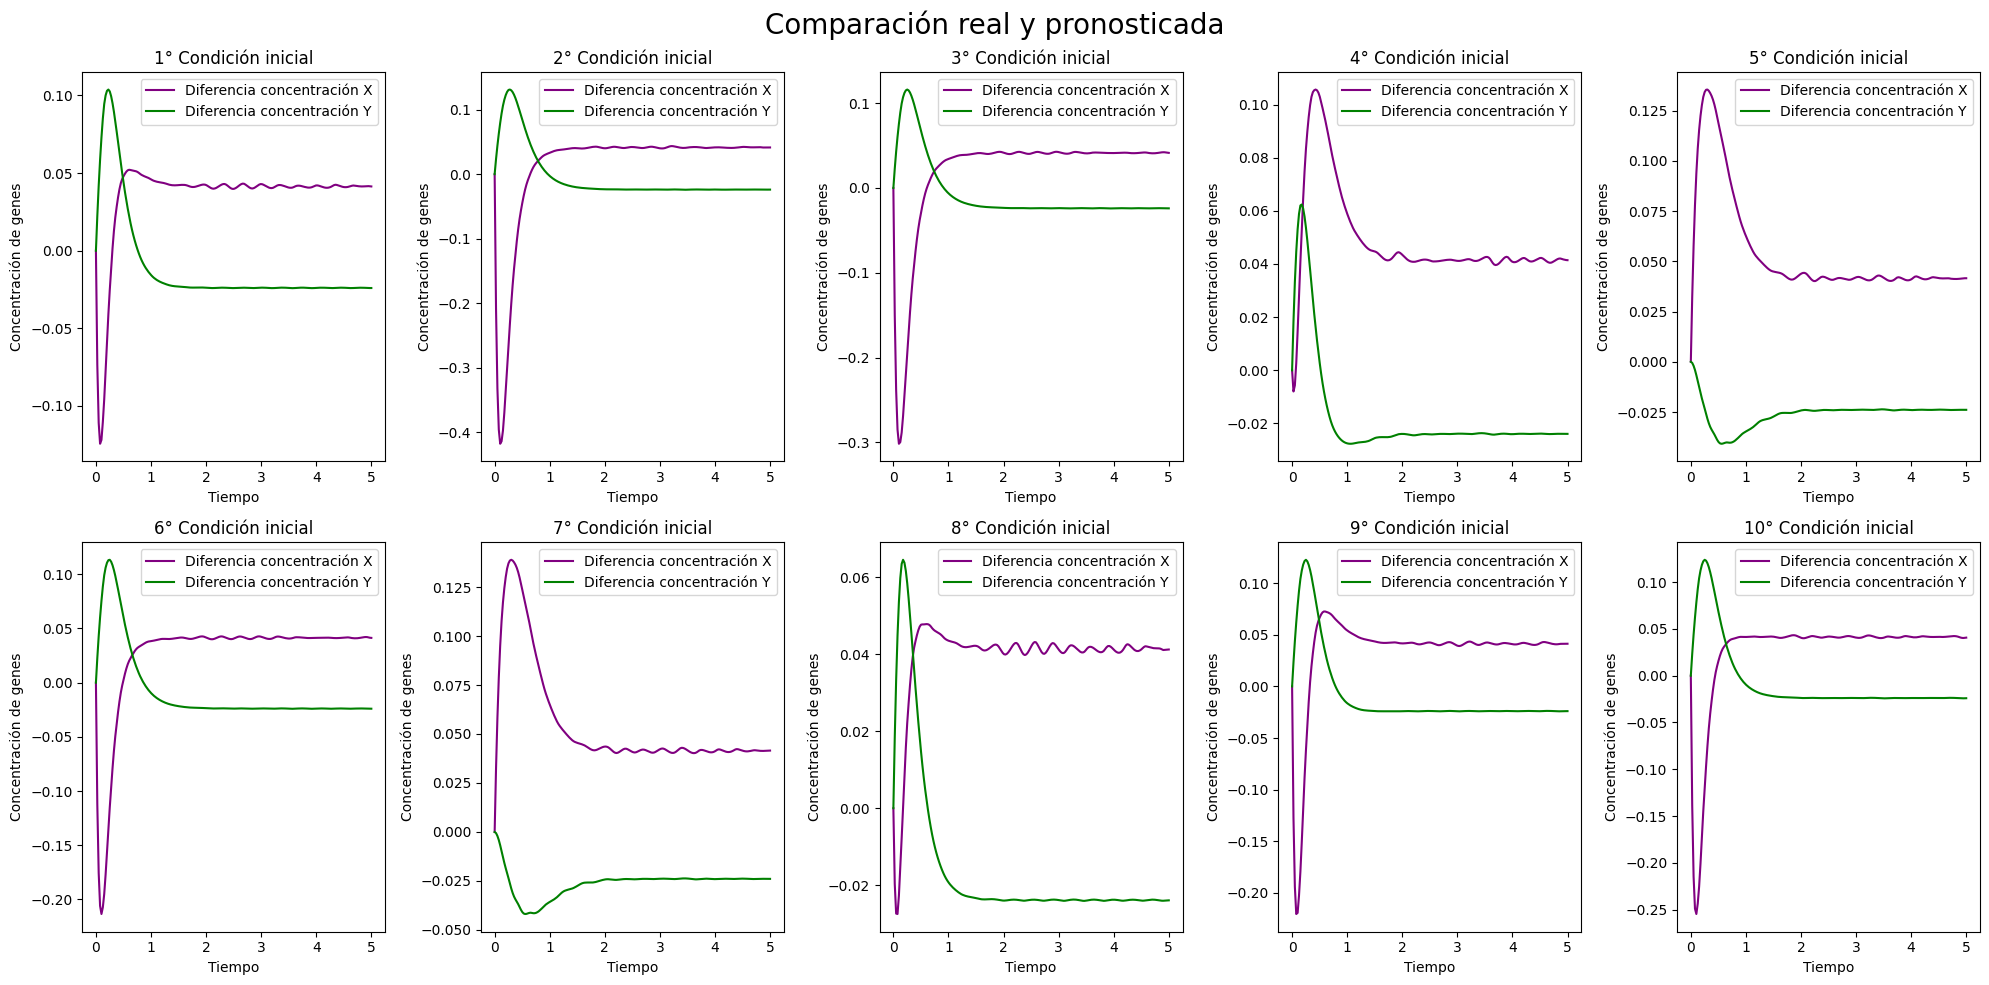

In [18]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [24]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.049570190638893695
0.027724474803637947
